In [57]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

import os
import shutil
import random
import glob
import cv2

from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation, add, Concatenate
from keras.layers import MaxPooling2D, Conv2DTranspose, Dropout, Lambda

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# directories
main_dir = "/Users/khalidsaifullah/Desktop/CS512/AS4/AS4"
data_dir = os.path.join(main_dir, "oxford-iiit-pet")
scripts_dir = main_dir

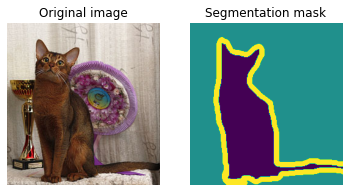

In [10]:
def disp_target(target_img): # visualize segmentation mask
    normalized_img = (target_img.astype("uint8") - 1) * 127
    plt.axis("off")
    return normalized_img

# visualize the data
img_number = 7

fig, (ax1, ax2) = plt.subplots(1, 2)

input_img= os.path.join(data_dir, "images", "Abyssinian_{}.jpg".format(img_number))
input_img = load_img(input_img)
label_img = os.path.join(data_dir, "annotations", "trimaps", "Abyssinian_{}.png".format(img_number))
label_img = load_img(label_img, color_mode="grayscale")
    
ax1.imshow(input_img)
ax1.set_title("Original image")
ax1.axis("off")

label_img = img_to_array(label_img)
normalized_img = disp_target(label_img)
ax2.imshow(normalized_img[:, : , 0])
ax2.set_title("Segmentation mask")
ax2.axis("off")

plt.show()


In [11]:
sink_dir_img = os.path.join( data_dir, "processed_data", "images")
sink_dir_labels = os.path.join( data_dir, "processed_data", "annotations")

if not os.path.exists(sink_dir_img):
    os.makedirs( sink_dir_img )
if not os.path.exists(sink_dir_labels):
    os.makedirs( sink_dir_labels )

image_filename = os.path.join(data_dir, "processed_data", "images_original_name.txt") # this is where we save the names of the images
label_filename = os.path.join(data_dir, "processed_data", "labels_of_original_name.txt") # this is where we save the names of the labels

cat_count = 0
dog_count = 0
for file_name in os.listdir( os.path.join(data_dir, "images") ):
    if not file_name.endswith(".jpg"):
        continue
    if file_name[0].isupper():
        
        # save the name in the image_filename and place 1 in the label_filename
        with open(image_filename, "a") as f:
            f.write(file_name + "\n")
        with open(label_filename, "a") as f:
            f.write("1" + "\n") # label 1 for cat
            
        new_name = f"cat_{cat_count}.jpg"
        shutil.copy( os.path.join(data_dir, "images", file_name), os.path.join(sink_dir_img, new_name) )
        shutil.copy( os.path.join(data_dir, "annotations", "trimaps", file_name[:-4] + ".png"), os.path.join(sink_dir_labels, new_name[:-4] + ".png") )
        cat_count += 1

    else:

        # save the name in the image_filename and place 0 in the label_filename
        with open(image_filename, "a") as f:
            f.write(file_name + "\n")
        with open(label_filename, "a") as f:
            f.write("0" + "\n")   # label 0 for dog

        new_name = f"dog_{dog_count}.jpg"
        shutil.copy( os.path.join(data_dir, "images", file_name), os.path.join(sink_dir_img, new_name) )
        shutil.copy( os.path.join(data_dir, "annotations", "trimaps", file_name[:-4] + ".png"), os.path.join(sink_dir_labels, new_name[:-4] + ".png") )
        # print(new_name)
        dog_count += 1

print("Total number of cats: ", cat_count)
print("Total number of dogs: ", dog_count)
Total_labels = cat_count + dog_count
print("Total number of images: ", Total_labels)

Total number of cats:  2395
Total number of dogs:  4988
Total number of images:  7383


In [12]:
# move to the new directory
data_dir = os.path.join(data_dir, "processed_data")

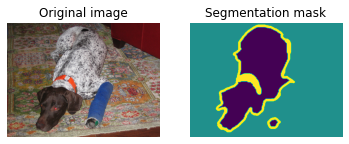

In [13]:
# visualize the images again
img_number = 20

fig, (ax1, ax2) = plt.subplots(1, 2)

input_img= os.path.join(data_dir, "images", "dog_{}.jpg".format(img_number))
input_img = load_img(input_img)
label_img = os.path.join(data_dir, "annotations", "dog_{}.png".format(img_number))
label_img = load_img(label_img, color_mode="grayscale")
    
ax1.imshow(input_img)
ax1.set_title("Original image")
ax1.axis("off")

label_img = img_to_array(label_img)
normalized_img = disp_target(label_img)
ax2.imshow(normalized_img[:, : , 0])
ax2.set_title("Segmentation mask")
ax2.axis("off")

plt.show()

In [16]:
# make train, validation and test sets and save them in the folders (portion of problem 1d)
if not ( os.path.exists(os.path.join(data_dir, "images", "train"))  and os.path.exists(os.path.join(data_dir, "images", "validation")) and os.path.exists(os.path.join(data_dir, "images", "test"))):
    os.makedirs( os.path.join(data_dir, "images", "train") )
    os.makedirs( os.path.join(data_dir, "images", "validation") )
    os.makedirs( os.path.join(data_dir, "images", "test") )

if not ( os.path.exists(os.path.join(data_dir, "annotations", "train"))  and os.path.exists(os.path.join(data_dir, "annotations", "validation")) and os.path.exists(os.path.join(data_dir, "annotations", "test"))):
    os.makedirs( os.path.join(data_dir, "annotations", "train") )
    os.makedirs( os.path.join(data_dir, "annotations", "validation") )
    os.makedirs( os.path.join(data_dir, "annotations", "test") )

In [17]:
def rename_files(image_folder_path, label_folder_path): # rename the files in the folder
    image_files = os.listdir(image_folder_path)
    label_files = os.listdir(label_folder_path)

    # Sort both lists of files
    image_files.sort()
    label_files.sort()
    
    # Create new folders for renamed files
    renamed_image_folder_path = os.path.join(image_folder_path, 'renamed_images')
    renamed_label_folder_path = os.path.join(label_folder_path, 'renamed_labels')
    os.makedirs(renamed_image_folder_path, exist_ok=True)
    os.makedirs(renamed_label_folder_path, exist_ok=True)

    # Copy image and label files to new folders with new names
    for i, (image_file, label_file) in enumerate(zip(image_files, label_files)):
        new_filename = f'{i:06}.jpg'
        new_labelname = f'{i:06}.png'
        shutil.copy(os.path.join(image_folder_path, image_file), os.path.join(renamed_image_folder_path, new_filename))
        shutil.copy(os.path.join(label_folder_path, label_file), os.path.join(renamed_label_folder_path, new_labelname))


In [18]:
images_folder_path = os.path.join(data_dir, "images")
labels_folder_path = os.path.join(data_dir, "annotations")

rename_files(images_folder_path, labels_folder_path)

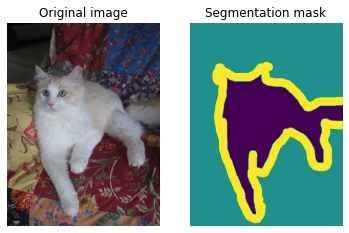

In [19]:
# visualize the images again 
img_number = 110 # change this number to visualize different images

fig, (ax1, ax2) = plt.subplots(1, 2)

input_img= os.path.join(data_dir, "images", "renamed_images", "{:06d}".format(img_number) + ".jpg")
input_img = load_img(input_img)
label_img = os.path.join(data_dir, "annotations", "renamed_labels", "{:06d}".format(img_number) + ".png")
label_img = load_img(label_img, color_mode="grayscale")
    
ax1.imshow(input_img)
ax1.set_title("Original image")
ax1.axis("off")

label_img = img_to_array(label_img)
normalized_img = disp_target(label_img)
ax2.imshow(normalized_img[:, : , 0])
ax2.set_title("Segmentation mask")
ax2.axis("off")

plt.show()

In [20]:
# make train, val and test ratio (portion of problem 1d)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

In [21]:
number_train_images = int(train_ratio * Total_labels)
number_val_images = int(val_ratio * Total_labels)
number_test_images = int(Total_labels - number_train_images - number_val_images)

print("Number of train images: ", number_train_images)
print("Number of val images: ", number_val_images)
print("Number of test images: ", number_test_images)


Number of train images:  5906
Number of val images:  738
Number of test images:  739


In [22]:
# make train, val and test folders in images
if not ( os.path.exists(os.path.join(data_dir, "images", "train"))  and os.path.exists(os.path.join(data_dir, "images", "validation")) and os.path.exists(os.path.join(data_dir, "images", "test"))):
    os.makedirs( os.path.join(data_dir, "images", "train") )
    os.makedirs( os.path.join(data_dir, "images", "validation") )
    os.makedirs( os.path.join(data_dir, "images", "test") )
# make train, val and test folders in annotations
if not ( os.path.exists(os.path.join(data_dir, "annotations", "train"))  and os.path.exists(os.path.join(data_dir, "annotations", "validation")) and os.path.exists(os.path.join(data_dir, "annotations", "test"))):
    os.makedirs( os.path.join(data_dir, "annotations", "train") )
    os.makedirs( os.path.join(data_dir, "annotations", "validation") )
    os.makedirs( os.path.join(data_dir, "annotations", "test") )

# move the files to the train, val and test folders from the renamed folders
for k in range(number_train_images):
    i = k+1
    if os.path.isfile(os.path.join(data_dir, "images", "renamed_images", "{:06d}".format(i) + ".jpg")) and os.path.isfile(os.path.join(data_dir, "annotations", "renamed_labels", "{:06d}".format(i) + ".png")):
        shutil.move( os.path.join(data_dir, "images", "renamed_images", "{:06d}".format(i) + ".jpg"), os.path.join(data_dir, "images", "train") )
        shutil.move( os.path.join(data_dir, "annotations", "renamed_labels", "{:06d}".format(i) + ".png"), os.path.join(data_dir, "annotations", "train") )

for k in range(number_train_images, number_train_images + number_val_images):
    i = k + 1
    if os.path.isfile(os.path.join(data_dir, "images", "renamed_images", "{:06d}".format(i) + ".jpg")) and os.path.isfile(os.path.join(data_dir, "annotations", "renamed_labels", "{:06d}".format(i) + ".png")):
        shutil.move( os.path.join(data_dir, "images", "renamed_images", "{:06d}".format(i) + ".jpg"), os.path.join(data_dir, "images", "validation") )
        shutil.move( os.path.join(data_dir, "annotations", "renamed_labels", "{:06d}".format(i) + ".png"), os.path.join(data_dir, "annotations", "validation") )

for k in range(number_train_images + number_val_images, Total_labels):
    i = k + 1
    if os.path.isfile(os.path.join(data_dir, "images", "renamed_images", "{:06d}".format(i) + ".jpg")) and os.path.isfile(os.path.join(data_dir, "images", "renamed_images", "{:06d}".format(i) + ".jpg")):   
        shutil.move( os.path.join(data_dir, "images", "renamed_images", "{:06d}".format(i) + ".jpg"), os.path.join(data_dir, "images", "test") )
        shutil.move( os.path.join(data_dir, "annotations", "renamed_labels", "{:06d}".format(i) + ".png"), os.path.join(data_dir, "annotations", "test") )


In [23]:
# remove the renamed folders
shutil.rmtree( os.path.join(data_dir, "images", "renamed_images") )
shutil.rmtree( os.path.join(data_dir, "annotations", "renamed_labels") )

## CNN Model

In [222]:
# parameters

num_classes = 1
epochs = 20

In [223]:
# Generate a unet with skip connections for our model
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)
    return x

#Encoder block:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation
def decoderblock_withskip(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
#skip features gets input from encoder for concatenation
def decoderblock_withoutskip(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    # x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet with skip connections using the blocks
def build_unet_withskip(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512) # Bridge

    d1 = decoderblock_withskip(b1, s4, 512)
    d2 = decoderblock_withskip(d1, s3, 256)
    d3 = decoderblock_withskip(d2, s2, 128)
    d4 = decoderblock_withskip(d3, s1, 64)
    
    f1 = conv_block(d4, 32)
    
    if n_classes == 1:  # For singular mask checking
      activation = 'sigmoid'
    else: # for multilevel label checking
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(f1)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="UNet")
    return model


#Build Unet without skip connections using the blocks
def build_unet_withoutskip(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512) # Bridge

    d1 = decoderblock_withoutskip(b1, s4, 512)
    d2 = decoderblock_withoutskip(d1, s3, 256)
    d3 = decoderblock_withoutskip(d2, s2, 128)
    d4 = decoderblock_withoutskip(d3, s1, 64)
    
    f1 = conv_block(d4, 32)
    
    if n_classes == 1:  # For singular mask checking
      activation = 'sigmoid'
    else: # for multilevel label checking
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(f1)  #Change the activation based on n_classes
#     print(activation)

    model = Model(inputs, outputs, name="UNet")
    return model

In [225]:
def loading_data(dirs, img_size, imgs=None, labels=None):
    if imgs is None:
        imgs = []
    if labels is None:
        labels = []
    
    # list all the filenames in dirs[0]
    filenames = os.listdir(dirs[0])
    filenames = sorted(filenames)

    # list all the filenames in dirs[1]
    filenames2 = os.listdir(dirs[1])
    filenames2 = sorted(filenames2)

    for i in range(len(filenames)):

        img = load_img( os.path.join(dirs[0], filenames[i]), color_mode='rgb', target_size=img_size )
        img = img_to_array(img)
        img = img/255.0
        imgs.append(img)
        
        label = load_img( os.path.join(dirs[1], filenames2[i]) , color_mode="grayscale", target_size=img_size )
        label = img_to_array(label)
        threshold = 2
        label = np.where(label >= threshold, 1, 0)
        labels.append(label)
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    return imgs, labels

In [226]:
img_dir = os.path.join(data_dir, "images", "train")
label_dir = os.path.join(data_dir, "annotations", "train")

num_imgs = len(os.listdir(img_dir))

img_size = (128, 128)
imgs, labels = loading_data([img_dir, label_dir], img_size)

In [227]:
# print the shapes of the images and labels
print("Shape of images: ", imgs.shape)
print("Shape of labels: ", labels.shape)


Shape of images:  (5906, 128, 128, 3)
Shape of labels:  (5906, 128, 128, 1)


In [231]:
# load the validation data with this as well

# make imgs and labels to lists from numpy arrays so that we can append to them
imgs = list(imgs)
labels = list(labels) 

img_dir = os.path.join(data_dir, "images", "validation")
label_dir = os.path.join(data_dir, "annotations", "validation")

imgs, labels = loading_data([img_dir, label_dir], img_size, imgs, labels)

In [232]:
# print the shapes of the images and labels
print("Shape of images: ", imgs.shape)
print("Shape of labels: ", labels.shape)

Shape of images:  (6644, 128, 128, 3)
Shape of labels:  (6644, 128, 128, 1)


In [233]:
x = imgs
y = labels.astype("uint8")

print("Shape of x: ", x.shape)
print("Shape of y: ", y.shape)


Shape of x:  (6644, 128, 128, 3)
Shape of y:  (6644, 128, 128, 1)


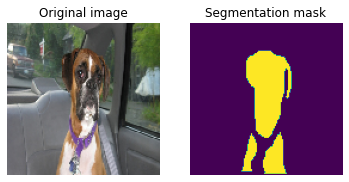

In [262]:
# visualize the images and labels

img_number = 4007 # change this number to visualize different images

fig, (ax1, ax2) = plt.subplots(1, 2)

 
ax1.imshow( x[img_number,:, :, :] )
ax1.set_title("Original image")
ax1.axis("off")

label_img = y[img_number, :, :, :]
label_img = img_to_array(label_img)
normalized_img = disp_target(label_img)
ax2.imshow(normalized_img[:, : , 0])
ax2.set_title("Segmentation mask")
ax2.axis("off")

plt.show()

In [235]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

In [236]:
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (4650, 128, 128, 3)
Shape of y_train:  (4650, 128, 128, 1)
Shape of x_test:  (1994, 128, 128, 3)
Shape of y_test:  (1994, 128, 128, 1)


In [240]:
img_size = (128, 128, 3)
model = build_unet_withoutskip(img_size, num_classes) #Without skip connections
# model = build_unet_withskip(img_size, num_classes) #With skip connections

model.summary()

sigmoid
Model: "UNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_152 (Bat (None, 128, 128, 32)      128       
_________________________________________________________________
activation_152 (Activation)  (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_153 (Bat (None, 64, 64, 64)       

In [241]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model
history=model.fit(x_train, 
          y_train,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/20
146/146 [==============================] - 510s 3s/step - loss: 0.4759 - accuracy: 0.7696 - val_loss: 1.0322 - val_accuracy: 0.5784
Epoch 2/20
146/146 [==============================] - 506s 3s/step - loss: 0.3211 - accuracy: 0.8584 - val_loss: 0.7317 - val_accuracy: 0.6937
Epoch 3/20
146/146 [==============================] - 513s 4s/step - loss: 0.2864 - accuracy: 0.8759 - val_loss: 0.7877 - val_accuracy: 0.7328
Epoch 4/20
146/146 [==============================] - 510s 3s/step - loss: 0.2549 - accuracy: 0.8909 - val_loss: 0.3104 - val_accuracy: 0.8750
Epoch 5/20
146/146 [==============================] - 503s 3s/step - loss: 0.2330 - accuracy: 0.9008 - val_loss: 0.2755 - val_accuracy: 0.8836
Epoch 6/20
146/146 [==============================] - 526s 4s/step - loss: 0.2238 - accuracy: 0.9048 - val_loss: 0.3052 - val_accuracy: 0.8709
Epoch 7/20
146/146 [==============================] - 536s 4s/step - loss: 0.2096 - accuracy: 0.9108 - val_loss: 0.2432 - val_accuracy: 0.8986

In [243]:
model.save('/Users/khalidsaifullah/Desktop/CS512/AS4/AS4/question1/models/Model_save.h5')

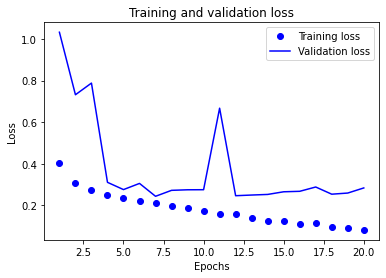

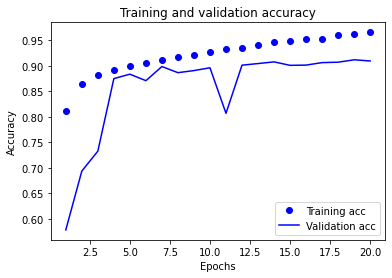

In [246]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the learning curves
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()